# Sample Segmentation II
This is a second pass on the segmentation algorithm implemented in Tan et. al. The segmentation pipeline consists of three broad steps:
1. initial segmentation by watershed;
1. refinement through active contours;
1. application of Markov Random Field (MRF) for part-solid lesions.

## Initial Segmentation by Watershed

In plain language, the following steps were/will be taken:
1. the user defines an ellipse on the slice of the CT where the lesion resides (ideally, where the diameter of the lesion is at its largest in the axial plane);
1. based upon this ellipse, a sub-volume is defined on a reference slice in the image for further analysis -- the sub-volume is essentially an elliptical cylinder -- so we take the coordinates of the ellipse in the reference slice, but also the coordinates in adjacent slices (both superior and inferior wrt the reference slice);
1. the number of adjacent slices considered is given by the following formula: $(a+b)\times PS$, where $PS$ is the native pixel spacing in the axial plane;
1. the sub-volume is then isotropically resampled to axial in-plane resolution (the thickness of the CT slices will vary, but most should be between 2.5-5mm); **NOT IMPLEMENTED IN CODE BELOW**
1. an initial segmentation is performed using the watershed algorithm -- this requires the definition of a marker image: a marker inside the lesion and a marker outside the lesion -- the internal marker will be the centroid of the lesion and the external marker will be the lung parenchyma and area surrounding the sub-volume in the image;
1. to determine the *true* centroid of the lesion, a threshold was applied to the sub-volume, where any pixel with intensity above the threshold was considered to be a candidate lesion pixel and anything below the threshold was considered to be a candidate lung paremchyma pixel;
1. the threshold can be determined through the application of a Gaussian Mixture model (sklearn);
1. the resultant binary mask is sequentially opened and closed to eliminate extrusions;
1. if the mean density of the pixels contained within this mask is <-150HU, the lesion would be considered as part-solid, meaning the extra step of the Random Markov Field (RMF) would be applied (explained in subsequent steps);
1. application of the distance transform yields the *true* centroid, which functions as the internal marker for the watershed;
1. anything outside the sub-volume *or* <870HU *or* >200HU can be considered as background markers;
1. a gradient image will be the input for the watershed;
1. to improve results on the watershed segmentation, a bowl function was applied to the ellipse within the sub-volume on the gradient image to suppress edges within the lesion -- the function essentially assigns a weight to each gradient pixel intensity based on how far it is from the lesion centre ($(r/R)^2$ for $r<R$ and $1$ for $R>=R$ where $R$ is the radius of the ellipse);
1. markers made the only local minimums by morphological reconstruction;

## Refinement through Active Contours
The paper describes a process that makes my brain hurt to read about -- lots of math and flashbacks to quantum mechanics courses. But...basically, all we would need to do is feed the initial segmentation into an active contour model. I would suggest we follow this example: https://scikit-image.org/docs/dev/auto_examples/edges/plot_active_contours.html, where:
- init is the watershed segmentation and
- image is the original image (try with and without Gaussian filtering)


In [49]:
import nrrd
from scripts.ImageSliceViewer3D import ImageSliceViewer3D as isv 

# paths to image and corresponding mask
im_path = 'data/images/LIDC-IDRI-0001.nrrd'
msk_path = 'data/masks/LIDC-IDRI-0001.nrrd'

im_V,im_d = nrrd.read(im_path)
msk_V,msk_d = nrrd.read(msk_path)

In [60]:
from skimage.measure import label,regionprops
# regionprops?
# label the mask into connected regions
nodule_labels,num_labels = label(msk_V,return_num=True)
nodule_props = regionprops(nodule_labels)

# the number of nodules in nodule_props corresponds to the number of connected regions
print('There are {} nodule(s) in this image.'.format(num_labels))     

There are 1 nodule(s) in this image.


In [5]:
# isolate the centroid of the nodule -- this will be our marker for the watershed algorithm
nodule_props[0].centroid
centroid = [round(i) for i in nodule_props[0].centroid] 
centroid


bbox = nodule_props[0].bbox  # to help construct cylinder_image

In [6]:
bbox_dims = [bbox[3]-bbox[0],bbox[4]-bbox[1],bbox[-1]-bbox[2]]
bbox_dims

[45, 37, 8]

In [151]:
import numpy as np

r = bbox_dims[0]/2 + bbox_dims[1]/2  # take a circle with radius larger than bounding box
r = max(bbox_dims)*2/3

r

30.0

In [152]:
circle_mask = np.zeros((im_V.shape[0],im_V.shape[1]),dtype=bool)
circle_mask.shape

row,col = np.meshgrid(range(circle_mask.shape[0]),range(circle_mask.shape[1]))
circle_mask[((row-centroid[1])**2+(col-centroid[0])**2)<r**2] = True

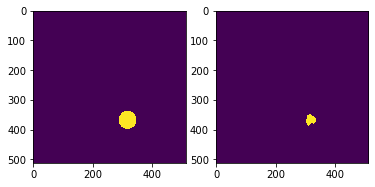

In [153]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(circle_mask)
axes[1].imshow(msk_V[:,:,centroid[2]])

In [154]:
# now we have the initial contour (that will theoretically be user-defined for the clinical dataset)
# next step: extend the circle in both superior and inferior directions to obtain a cylinder

# determine the number of slices required in the z direction for full coverage
num_slices = int(np.ceil((float(im_d['pixel_spacing']) * r) / float(im_d['slice_thickness'])/2))
num_slices

5

In [155]:
cylinder_image = np.zeros((im_V.shape[0],im_V.shape[1],im_V.shape[2]),dtype=bool)

for i in range(centroid[-1]-num_slices,centroid[-1]+num_slices+1):
    cylinder_image[:,:,i] = circle_mask

In [156]:
# label the mask into connected regions
mask_labels = label(cylinder_image)
mask_props = regionprops(mask_labels)

coords = mask_props[0].bbox

msk_subV = mask_props[0].image
img_subV = im_V[coords[0]:coords[3],coords[1]:coords[4],coords[2]:coords[-1]]
# isolate the sub-volume of the cylinder -- all operations applied to this, then it can be mapped back using bbox
isv(img_subV)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

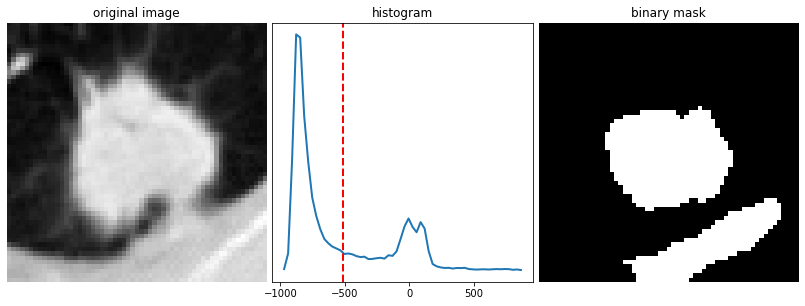

-512.5576745709648

In [161]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage.morphology import opening, ball

intensities = img_subV[msk_subV]

hist, bin_edges = np.histogram(intensities, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

classif = GaussianMixture(n_components=2)
classif.fit(intensities.reshape(-1,1))

threshold = np.mean(classif.means_)
binary_img = np.logical_and(np.logical_and(img_subV > threshold,img_subV > -850),img_subV < 200)
binary_img[~msk_subV] = False
binary_img_centroid = opening(binary_img,ball(radius=int(0.1*r)))


plt.figure(figsize=(11,4))

plt.subplot(131)
plt.imshow(img_subV[:,:,5],cmap='binary_r')
plt.title('original image')
plt.axis('off')
plt.subplot(132)
plt.plot(bin_centers, hist, lw=2)
plt.axvline(threshold, color='r', ls='--', lw=2)
plt.title('histogram')
plt.yticks([])
plt.subplot(133)
plt.imshow(binary_img_centroid[:,:,5], cmap=plt.cm.gray, interpolation='nearest')
plt.title('binary mask')
plt.axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
plt.show()
threshold

In [162]:
# label the mask into connected regions
lesion_labels = label(binary_img_centroid)
lesion_props = regionprops(lesion_labels)

areas = [lesion_props[i].area for i in range(len(lesion_props))]
ind = np.where(areas==np.max(areas))

# ind[0][0]
centroid_subV = lesion_props[ind[0][0]].centroid
centroid_subV

(29.93583051888241, 28.855081363217685, 4.952103162419404)

In [163]:
# construct a marker image for the watershed
marker_image = np.zeros((img_subV.shape[0],img_subV.shape[1],img_subV.shape[2]),dtype=np.uint8)
marker_image[~binary_img] = 1   # background voxels
marker_image[round(centroid_subV[0]),round(centroid_subV[1]),round(centroid_subV[2])] = 2 # reassigned centroid

isv(marker_image)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [108]:
from skimage.segmentation import watershed
from skimage.filters import gaussian
from skimage.morphology import erosion, dilation

# watershed?

# denoise image
denoised = gaussian(img_subV)

# try some funky stuff
max_image = dilation(denoised,ball(2))
min_image = erosion(denoised,ball(2))

gradient_image = max_image - min_image

isv(gradient_image)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [93]:
# import denseCRF3D